# Regression simulation (revised)

### Step 1: Assumptions
Assume that synaptic density (synpases/unmasked), Y, follows some joint distribution $F_{Y \mid X}$ where $X$ is the set of data, which are vectors in $\mathbb{R}^3$ and its elements correspond, respectively, to x, y, z coordinates given by the data.

### Step 2: Define model
Let the true values of density correspond to the set Y, and let the joint distribution be parameterized by $\theta$. So for each $x_i \in X \textrm{ and } y_i \in Y \ , F(x;\theta)=y$. 

We want to find parameters $\hat \theta$ such that we minimize a loss function $l(\hat y, y)$, where $\hat y = F(x;\hat \theta)$.

### Step 3: Algorithms
- Linear Regression
- Support Vector Regression (SVR)
- K-Nearest Neighbor Regression (KNN)
- Random Forest Regression (RF)
- Polynomial Regression

### Setup

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import urllib2
from __future__ import division

np.random.seed(1)
url = ('https://raw.githubusercontent.com/Upward-Spiral-Science'
       '/data/master/syn-density/output.csv')
data = urllib2.urlopen(url)
csv = np.genfromtxt(data, delimiter=",")[1:] # don't want first row (labels)

# chopping data based on thresholds on x and y coordinates
x_bounds = (409, 3529)
y_bounds = (1564, 3124)

def check_in_bounds(row, x_bounds, y_bounds):
    if row[0] < x_bounds[0] or row[0] > x_bounds[1]:
        return False
    if row[1] < y_bounds[0] or row[1] > y_bounds[1]:
        return False
    if row[3] == 0:
        return False

    return True

indices_in_bound, = np.where(np.apply_along_axis(check_in_bounds, 1, csv, x_bounds, y_bounds))
data_thresholded = csv[indices_in_bound]
n = data_thresholded.shape[0]
data = data_thresholded
data[:, -2] = data[:,-1]/data[:,-2]
data = data[:, :-1]
print data[:, -1]
# normalize  density so they're not super tiny values
data[:, -1] -= np.average(data[:, -1])
data[:, -1] /= np.std(data[:, -1])
print data[:, -1]

[ 0.00152724  0.00160285  0.00162364 ...,  0.00092469  0.00060045
  0.00093872]
[ 0.92781019  1.11377747  1.1649147  ..., -0.55424367 -1.35176376
 -0.51974171]


### Step 4/5/6 part A: Null distribution

No relationship, i.e. density is independent of position. Let's just let density be uniform across the entire 3D space defined by the dataset. So the target variable Y, i.e. unmasked, follows a uniform distribution.

In [13]:
mins = [np.min(csv[:,i]) for i in xrange(4)]
maxs = [np.max(csv[:,i]) for i in xrange(4)]
domains = zip(mins, maxs)

# sample sizes
S = np.logspace(2.0, 4.0, num=20, base=10.0, dtype='int')

null_X = np.array([[np.random.randint(*domains[i]) for i in xrange(3)] 
                   for k in xrange(S[-1])])
null_Y = np.random.uniform(*domains[-1], size=S[-1])
print null_X.shape, null_Y.shape

(10000, 3) (10000,)


In [15]:
# load our regressions
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.pipeline import Pipeline
from sklearn import cross_validation
names = ['Linear Regression','SVR','KNN Regression','Random Forest Regression','Polynomial Regression']
regressions = [LinearRegression(),
               LinearSVR(C=1.0),
               KNN(n_neighbors=10, algorithm='auto'),
               RF(max_depth=5, max_features=1),
               Pipeline([('poly', PF(degree=2)),('linear', LinearRegression(fit_intercept=False))])]
r2 = np.zeros((len(S), len(regressions), 2), dtype=np.dtype('float64'))

#iterate over sample sizes and regression algos
for i, N in enumerate(S):
    # Randomly sample from synthetic data with sample size N
    a = np.random.permutation(np.arange(S[-1]))[:N]
    X = null_X[a]
    Y = null_Y[a]
    Y = np.ravel(Y)
    print "Sample size = ", N
    for k, reg in enumerate(regressions):
        scores = cross_validation.cross_val_score(reg, X, Y, scoring='r2', cv=10)
        r2[i, k, :] = [scores.mean(), scores.std()]
        print("R^2 of %s: %0.2f (+/- %0.2f)" % (names[k], scores.mean(), scores.std() * 2))

Sample size =  100
R^2 of Linear Regression: -0.21 (+/- 0.38)
R^2 of SVR: -0.37 (+/- 0.64)
R^2 of KNN Regression: -0.36 (+/- 0.99)
R^2 of Random Forest Regression: -0.45 (+/- 1.19)
R^2 of Polynomial Regression: -0.36 (+/- 0.35)
Sample size =  127
R^2 of Linear Regression: -0.06 (+/- 0.17)
R^2 of SVR: -0.13 (+/- 0.47)
R^2 of KNN Regression: -0.08 (+/- 0.28)
R^2 of Random Forest Regression: -0.22 (+/- 0.45)
R^2 of Polynomial Regression: -0.16 (+/- 0.59)
Sample size =  162
R^2 of Linear Regression: -0.06 (+/- 0.17)
R^2 of SVR: -0.20 (+/- 0.47)
R^2 of KNN Regression: -0.13 (+/- 0.39)
R^2 of Random Forest Regression: -0.16 (+/- 0.39)
R^2 of Polynomial Regression: -0.12 (+/- 0.30)
Sample size =  206
R^2 of Linear Regression: -0.03 (+/- 0.09)
R^2 of SVR: -0.18 (+/- 0.20)
R^2 of KNN Regression: -0.18 (+/- 0.26)
R^2 of Random Forest Regression: -0.15 (+/- 0.22)
R^2 of Polynomial Regression: -0.10 (+/- 0.14)
Sample size =  263
R^2 of Linear Regression: -0.05 (+/- 0.11)
R^2 of SVR: -0.14 (+/- 0.3

Now graphing this data:

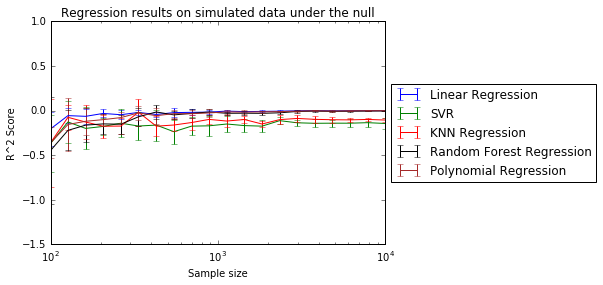

In [17]:
plt.errorbar(S, r2[:,0,0], yerr = r2[:,0,1], hold=True, label=names[0])
plt.errorbar(S, r2[:,1,0], yerr = r2[:,1,1], color='green', hold=True, label=names[1])
plt.errorbar(S, r2[:,2,0], yerr = r2[:,2,1], color='red', hold=True, label=names[2])
plt.errorbar(S, r2[:,3,0], yerr = r2[:,3,1], color='black', hold=True, label=names[3])
plt.errorbar(S, r2[:,4,0], yerr = r2[:,4,1], color='brown', hold=True, label=names[4])
plt.xscale('log')
plt.axhline(1, color='red', linestyle='--')
plt.xlabel('Sample size')
plt.ylabel('R^2 Score')
plt.title('Regression results on simulated data under the null')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Step 4/5/6 part b: Alternate distribution

Here we want assume a conditional dependence. Let's keep the x, y, z uniformly distributed across the sample space, but let density, $y_i$, be the sum of a deterministic function, $f:\mathbb{R}^3 \rightarrow \mathbb{R}$, and $\epsilon$ some Gaussian noise with low std dev and 0 mean. Let $f(x,y,z)=x+y+z$ (normalized over the average of all f). Let the variance of $\epsilon$ be .01.

In [22]:
# X under the alt same as under the null
alt_X = null_X
f_X = np.apply_along_axis(lambda r: reduce(lambda x,y:x+y, r)/3, 1, alt_X)
f_X -= np.average(f_X)
f_X /= np.std(f_X)
alt_Y = np.random.normal(0, .01, size=f_X.shape)+f_X
print alt_Y.shape

(10000,)


In [23]:
r2 = np.zeros((len(S), len(regressions), 2), dtype=np.dtype('float64'))
#iterate over sample sizes and regression algos
for i, N in enumerate(S):
    # Randomly sample from synthetic data with sample size N
    a = np.random.permutation(np.arange(S[-1]))[:N]
    X = alt_X[a]
    Y = alt_Y[a]
    Y = np.ravel(Y)
    print "Sample size = ", N
    for k, reg in enumerate(regressions):
        scores = cross_validation.cross_val_score(reg, X, Y, scoring='r2', cv=10)
        r2[i, k, :] = [scores.mean(), scores.std()]
        print("R^2 of %s: %0.2f (+/- %0.2f)" % (names[k], scores.mean(), scores.std() * 2))

Sample size =  100
R^2 of Linear Regression: 1.00 (+/- 0.00)
R^2 of SVR: -0.64 (+/- 1.79)
R^2 of KNN Regression: 0.95 (+/- 0.05)
R^2 of Random Forest Regression: 0.86 (+/- 0.20)
R^2 of Polynomial Regression: 1.00 (+/- 0.00)
Sample size =  127
R^2 of Linear Regression: 1.00 (+/- 0.00)
R^2 of SVR: -0.12 (+/- 1.38)
R^2 of KNN Regression: 0.94 (+/- 0.05)
R^2 of Random Forest Regression: 0.81 (+/- 0.18)
R^2 of Polynomial Regression: 1.00 (+/- 0.00)
Sample size =  162
R^2 of Linear Regression: 1.00 (+/- 0.00)
R^2 of SVR: -1.25 (+/- 4.25)
R^2 of KNN Regression: 0.96 (+/- 0.03)
R^2 of Random Forest Regression: 0.82 (+/- 0.20)
R^2 of Polynomial Regression: 1.00 (+/- 0.00)
Sample size =  206
R^2 of Linear Regression: 1.00 (+/- 0.00)
R^2 of SVR: -0.28 (+/- 1.31)
R^2 of KNN Regression: 0.97 (+/- 0.04)
R^2 of Random Forest Regression: 0.87 (+/- 0.10)
R^2 of Polynomial Regression: 1.00 (+/- 0.00)
Sample size =  263
R^2 of Linear Regression: 1.00 (+/- 0.00)
R^2 of SVR: -0.63 (+/- 2.93)
R^2 of KNN Reg

Now graphing it:

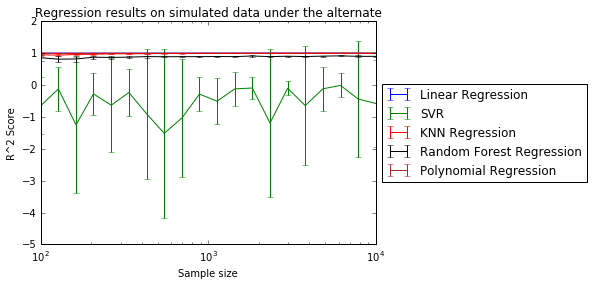

In [25]:
plt.errorbar(S, r2[:,0,0], yerr = r2[:,0,1], hold=True, label=names[0])
plt.errorbar(S, r2[:,1,0], yerr = r2[:,1,1], color='green', hold=True, label=names[1])
plt.errorbar(S, r2[:,2,0], yerr = r2[:,2,1], color='red', hold=True, label=names[2])
plt.errorbar(S, r2[:,3,0], yerr = r2[:,3,1], color='black', hold=True, label=names[3])
plt.errorbar(S, r2[:,4,0], yerr = r2[:,4,1], color='brown', hold=True, label=names[4])
plt.xscale('log')
plt.axhline(1, color='red', linestyle='--')
plt.xlabel('Sample size')
plt.ylabel('R^2 Score')
plt.title('Regression results on simulated data under the alternate')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Step 7: Apply on actual data

In [27]:
X = data[:, (0, 1, 2)]
Y = data[:, -1]
for i, reg in enumerate(regressions):
    scores = cross_validation.cross_val_score(reg, X, Y, scoring='r2', cv=10)
    print("R^2 of %s: %0.2f (+/- %0.2f)" % (names[i], scores.mean(), scores.std() * 2))

R^2 of Linear Regression: 0.12 (+/- 0.16)
R^2 of SVR: -0.73 (+/- 1.45)
R^2 of KNN Regression: 0.20 (+/- 0.08)
R^2 of Random Forest Regression: 0.22 (+/- 0.10)
R^2 of Polynomial Regression: 0.18 (+/- 0.17)


In [36]:
# boost number of neighbors for KNN and max depth for random forest
regressions = [KNN(n_neighbors=30, algorithm='auto'),
               RF(max_depth=10, max_features=1)]
names = ['KNN Regression', 'Random Forest Regression']
for i, reg in enumerate(regressions):
    scores = cross_validation.cross_val_score(reg, X, Y, scoring='r2', cv=10)
    print("R^2 of %s: %0.2f (+/- %0.2f)" % (names[i], scores.mean(), scores.std() * 2))

R^2 of KNN Regression: 0.23 (+/- 0.08)
R^2 of Random Forest Regression: 0.28 (+/- 0.07)


### Step 8: Reflect on results
The two most promising regression algorithms were KNN and Random Forest, but even then, R^2 values were low, indicating that the regressions were overall unsucessful.